In [41]:
#Load necessary modules
import os
#Some hacks to get around a Basemap issue
os.environ["PYTHONWARNINGS"]="ignore::yaml.YAMLLoadWarning"
import glob
import seaborn as sns
import numpy as np
import xarray as xa
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import nc_time_axis
import cftime
import scipy
import math
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from ordered_set import OrderedSet
from mpl_toolkits.axes_grid1 import make_axes_locatable
dats_mod=["CFSR","MERRA","ERA","JRA"]
#dats_mod2=["CMCC-CESM","CMCC-CM","CNRM-CM5",
#          "CanESM2","GFDL-CM3","GFDL-ESM2M",
          #"HadCM3","HadGEM2-CC","IPSL-CM5A",
#           "IPSL-CM5A",
#          "MIROC-ESM","MIROC5","MPI-ESM-MR",
#          "MRI-CGCM3","MRI-ESM1","NorESM1-M"]

dats_mod2=["CMCC-CM","MRI-CGCM3","MRI-ESM1",
          "MIROC5","CNRM-CM5","GFDL-ESM2M",
          "MPI-ESM-MR","NorESM1-M","IPSL-CM5A",
          "GFDL-CM3","CanESM2","MIROC-ESM","CMCC-CESM"]
dats_all = dats_mod + dats_mod2

dats_esm = ["MRI-ESM1","CNRM-CM5","GFDL-ESM2M",
           "MPI-ESM-MR","NorESM1-M","IPSL-CM5A",
           "CanESM2","MIROC-ESM","CMCC-CESM"]
dats_aog = ["CMCC-CM","MRI-CGCM3","MIROC5","GFDL-CM3"]


dats_cmip6=["EC-Earth3","CESM2","CESM2-WACCM",
            "BCC-CSM2-MR","MRI-ESM2-0",
           "IPSL-CM6A-LR","GFDL-CM4","GISS-E2-1-G",
           "CanESM5","BCC-ESM1"]

base_dir="/global/cscratch1/sd/marielp"
base_dir2="/global/cscratch1/sd/marielp/CMIP6"

In [42]:
avg_djf = xa.open_dataset('{:}/REAN_MODEL_MEANS_DJF.nc'.format(base_dir))
avg_jja = xa.open_dataset('{:}/REAN_MODEL_MEANS_JJA.nc'.format(base_dir))

cmip_djf=xa.open_dataset('{:}/REAN_CMIP6_MEANS_DJF.nc'.format(base_dir2))
cmip_jja=xa.open_dataset('{:}/REAN_CMIP6_MEANS_JJA.nc'.format(base_dir2))

In [43]:
month_djf=xa.open_dataset('{:}/REAN_MODEL_SEASON_MEANS_DJF.nc'.format(base_dir))
month_jja=xa.open_dataset('{:}/REAN_MODEL_SEASON_MEANS_JJA.nc'.format(base_dir))    
  
cmonth_djf=xa.open_dataset('{:}/REAN_CMIP6_SEASON_MEANS_DJF.nc'.format(base_dir2))
cmonth_jja=xa.open_dataset('{:}/REAN_CMIP6_SEASON_MEANS_JJA.nc'.format(base_dir2))   

In [44]:
#Calculate a matrix of difference significance
def sigtest(a,b,rean,mod):
    sig=ttest_ind(rean,mod,equal_var=False)
    pvalue=sig.pvalue

    return(pvalue)

def sigmat_calc(rean,model):
    s=rean.shape
    sigmat=np.ones(s[1:3])
    new_lons = np.arange(0.,360.)
    new_lats=np.arange(-90.,91.)
    
    for a in range(0,len(new_lats)):
        for b in range(0,len(new_lons)):
            if ((np.abs(new_lats[a])>27)&(np.abs(new_lats[a])<73)):
                rslice=rean.values[:,a,b]
                mslice=model.values[:,a,b]
                sumcheck=rslice+mslice
                if(np.sum(sumcheck)>0):
                    sigmat[a,b]=sigtest(a,b,rslice,mslice)
    return(sigmat)

In [45]:
sig_djf=sigmat_calc(month_djf['reanSeasonMean'],month_djf['modelSeasonMean'])
sig_jja=sigmat_calc(month_jja['reanSeasonMean'],month_jja['modelSeasonMean'])

csig_djf=sigmat_calc(cmonth_djf['reanSeasonMean'],cmonth_djf['modelSeasonMean'])
csig_jja=sigmat_calc(cmonth_jja['reanSeasonMean'],cmonth_jja['modelSeasonMean'])


In [77]:
def plot_format(ax,var,sstring,b_breaks,cmap):
    ax.set_title(sstring)
    im=ax.contourf(var.lon.values,var.lat.values,var.values,b_breaks,cmap=cmap)
    ax.contour(var.lon.values,var.lat.values,var.values,b_breaks,colors='black')
    m_r=Basemap(lon_0=180,ax=ax)
    m_r.drawcoastlines()
    return(im)

def plot_format2(ax,var,sstring,b_breaks,cmap,sigmat):
    ax.set_title(sstring)
    im=ax.contourf(var.lon.values,var.lat.values,var.values,b_breaks,cmap=cmap)
    ax.contour(var.lon.values,var.lat.values,var.values,b_breaks,colors='black')
    ax.contourf(var.lon.values,var.lat.values,sigmat,levels=[-0.01,0.05,1],hatches=['...',None],colors='none')

    m_r=Basemap(lon_0=180,ax=ax)
    m_r.drawcoastlines()
    return(im)

def plot_freqs(var1,sstr1,var2,sstr2,b_breaks,cmap):
    fig_r,ax_r= plt.subplots(1,2,figsize=(20,8),sharex="col",sharey="row")

    p1=plot_format(ax_r[0],var1,sstr1,b_breaks,cmap)
    p2=plot_format(ax_r[1],var2,sstr2,b_breaks,cmap)
    #new_ax = fig_r.add_axes([0.85,0.15,0.05,0.7])
    #fig_r.subplots_adjust(right=0.8)
    divider1 = make_axes_locatable(ax_r[0])
    cbar_ax1 = divider1.append_axes("right", size="5%", pad=0)
    cbar_ax1.axis('off')
    
    divider2 = make_axes_locatable(ax_r[1])
    cbar_ax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig_r.colorbar(p1, cax=cbar_ax2)
    #fig_r.colorbar(cm.ScalarMappable(norm=b_breaks, cmap="YlOrRd"), cax=cbar_ax)
    #fig_r.colorbar(p1,cax=cbar_ax)
    plt.tight_layout()

def plot_diffs_w_sig(var1,sstr1,var2,sstr2,b_breaks,cmap,sigmat1,sigmat2):
    fig_r,ax_r=plt.subplots(1,2,figsize=(20,8),sharex="col",sharey="row")
    p1=plot_format2(ax_r[0],var1,sstr1,b_breaks,cmap,sigmat1)
    p2=plot_format2(ax_r[1],var2,sstr2,b_breaks,cmap,sigmat2)

    
    divider1 = make_axes_locatable(ax_r[0])
    cbar_ax1 = divider1.append_axes("right", size="5%", pad=0)
    cbar_ax1.axis('off')
    
    divider2 = make_axes_locatable(ax_r[1])
    cbar_ax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig_r.colorbar(p1, cax=cbar_ax2)
    #fig_r.colorbar(cm.ScalarMappable(norm=b_breaks, cmap="YlOrRd"), cax=cbar_ax)
    #fig_r.colorbar(p1,cax=cbar_ax)
    plt.tight_layout()    

    

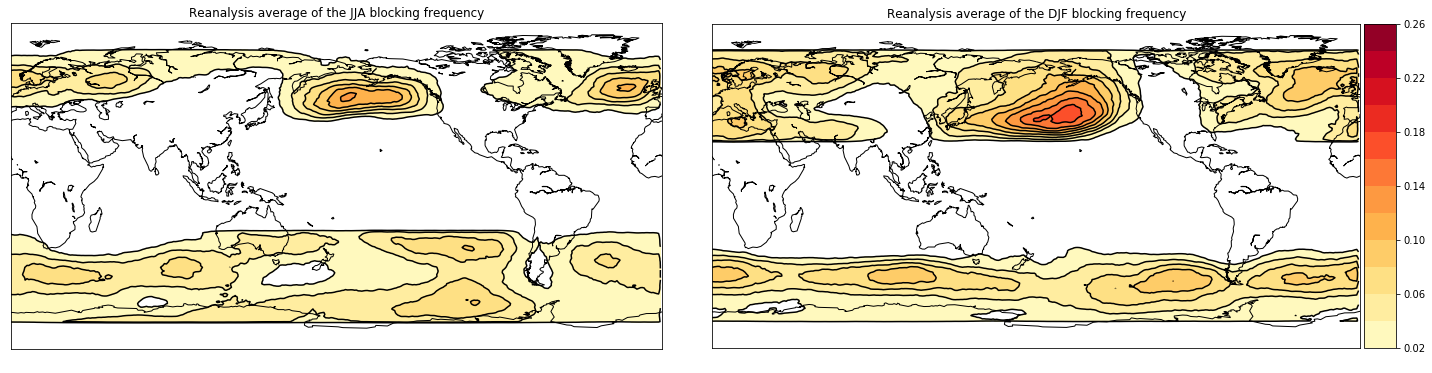

In [25]:
#Reanalysis
b_breaks=np.arange(0.02,0.28,0.02)
sstr1="Reanalysis average of the JJA blocking frequency"
sstr2="Reanalysis average of the DJF blocking frequency"
plot_freqs(avg_jja['reanBlockMean'],sstr1,avg_djf['reanBlockMean'],sstr2,b_breaks,"YlOrRd")

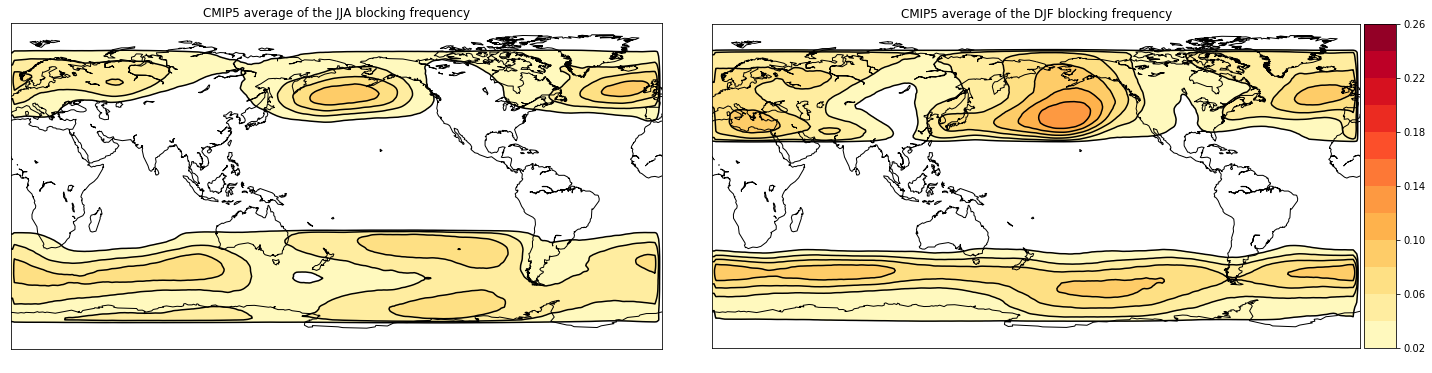

In [26]:
#Model
sstr1="CMIP5 average of the JJA blocking frequency"
sstr2="CMIP5 average of the DJF blocking frequency"
plot_freqs(avg_jja['modelBlockMean'],sstr1,avg_djf['modelBlockMean'],sstr2,b_breaks,"YlOrRd")

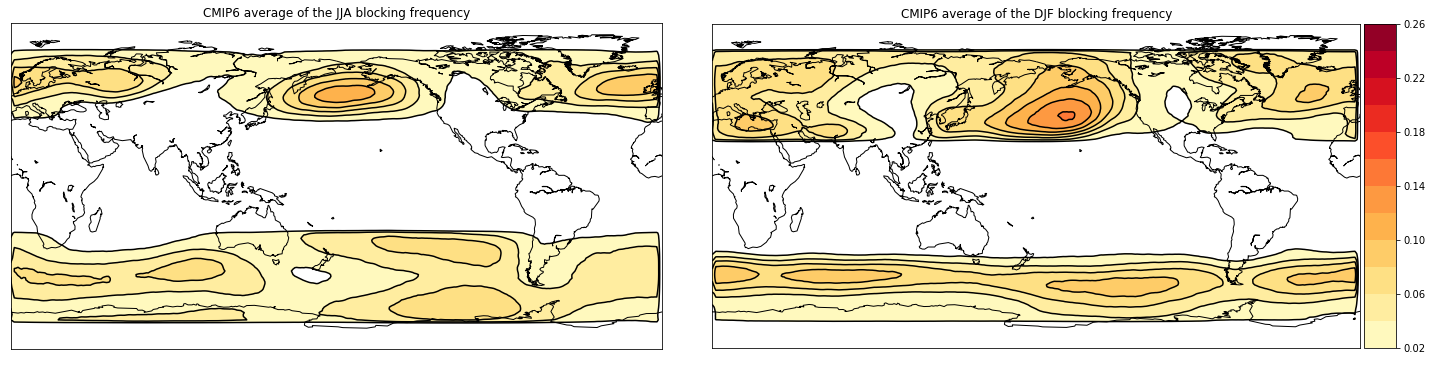

In [27]:
#CMIP6
b_breaks=np.arange(0.02,0.28,0.02)
sstr1="CMIP6 average of the JJA blocking frequency"
sstr2="CMIP6 average of the DJF blocking frequency"
plot_freqs(cmip_jja['modelBlockMean'],sstr1,cmip_djf['modelBlockMean'],sstr2,b_breaks,"YlOrRd")

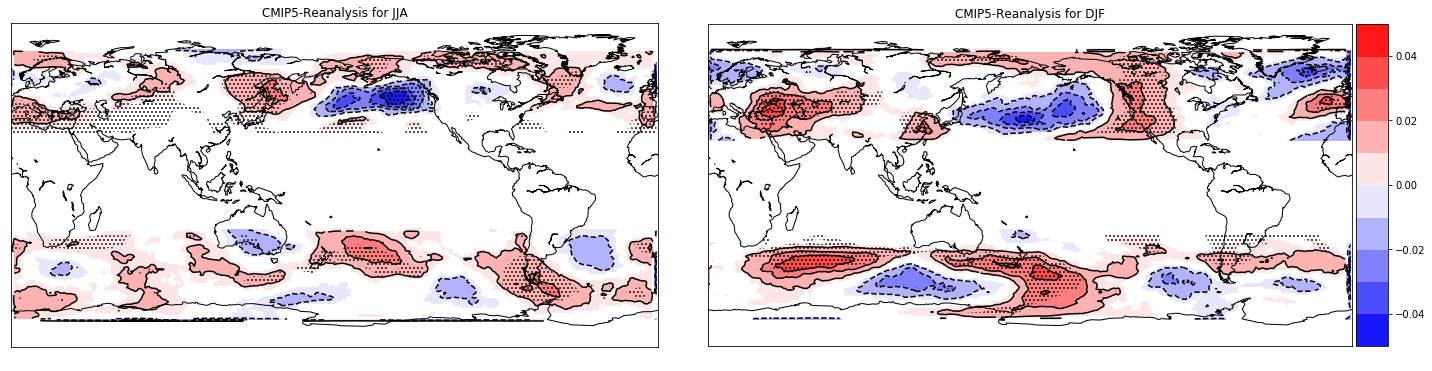

In [29]:
#Diffs
diff_breaks=np.arange(-0.05,0.06,0.01)
sstr1="CMIP5-Reanalysis for JJA"
sstr2="CMIP5-Reanalysis for DJF"
plot_diffs_w_sig(avg_jja['modelDiff'],sstr1,avg_djf['modelDiff'],sstr2,diff_breaks,"bwr",sig_jja,sig_djf)

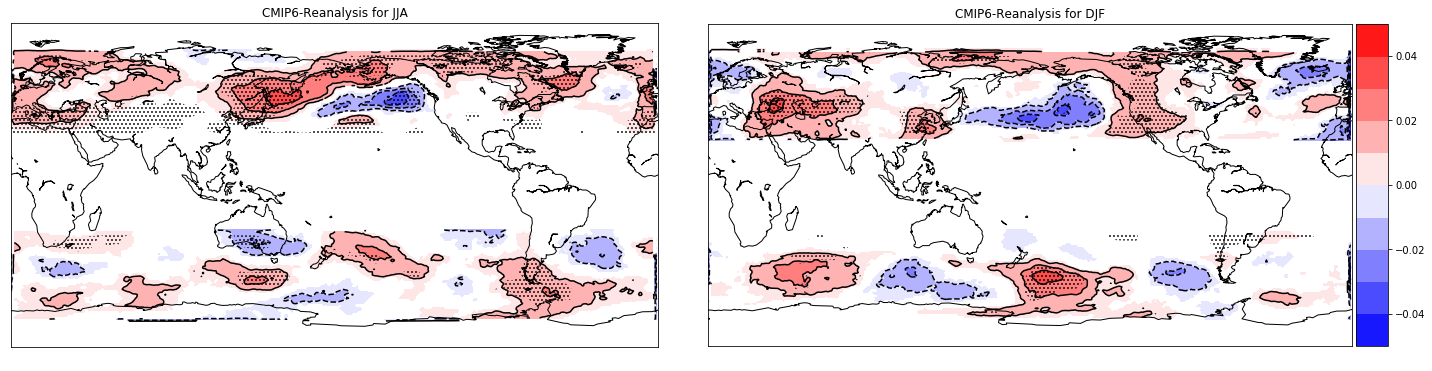

In [17]:
#Diffs between reanalysis and CMIP6
diff_breaks=np.arange(-0.05,0.06,0.01)
sstr1="CMIP6-Reanalysis for JJA"
sstr2="CMIP6-Reanalysis for DJF"
plot_diffs_w_sig(cmip_jja['modelDiff'],sstr1,cmip_djf['modelDiff'],sstr2,diff_breaks,"bwr",csig_jja,csig_djf)

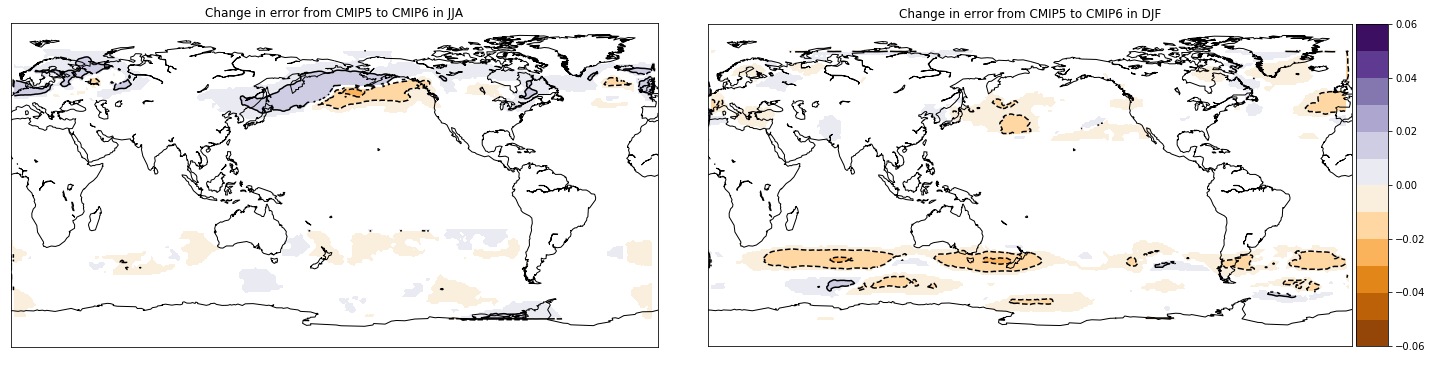

In [110]:
#Does it get better or worse from CMIP5 to CMIP6?
c6abs_djf=np.absolute(cmip_djf['modelBlockMean']-cmip_djf['reanBlockMean'])
c5abs_djf=np.absolute(avg_djf['modelBlockMean']-avg_djf['reanBlockMean'])
cdiff_djf=c6abs_djf-c5abs_djf

l0=np.absolute(cdiff_djf)<0.005
cdiff_djf.values[l0]=np.nan

c6abs_jja=np.absolute(cmip_jja['modelBlockMean']-cmip_jja['reanBlockMean'])
c5abs_jja=np.absolute(avg_jja['modelBlockMean']-avg_jja['reanBlockMean'])
cdiff_jja=c6abs_jja-c5abs_jja

l0=np.absolute(cdiff_jja)<0.005
cdiff_jja.values[l0]=np.nan


sstr1='Change in error from CMIP5 to CMIP6 in JJA'
sstr2='Change in error from CMIP5 to CMIP6 in DJF'
plot_freqs(cdiff_jja,sstr1,cdiff_djf,sstr2,diff_breaks,"PuOr")

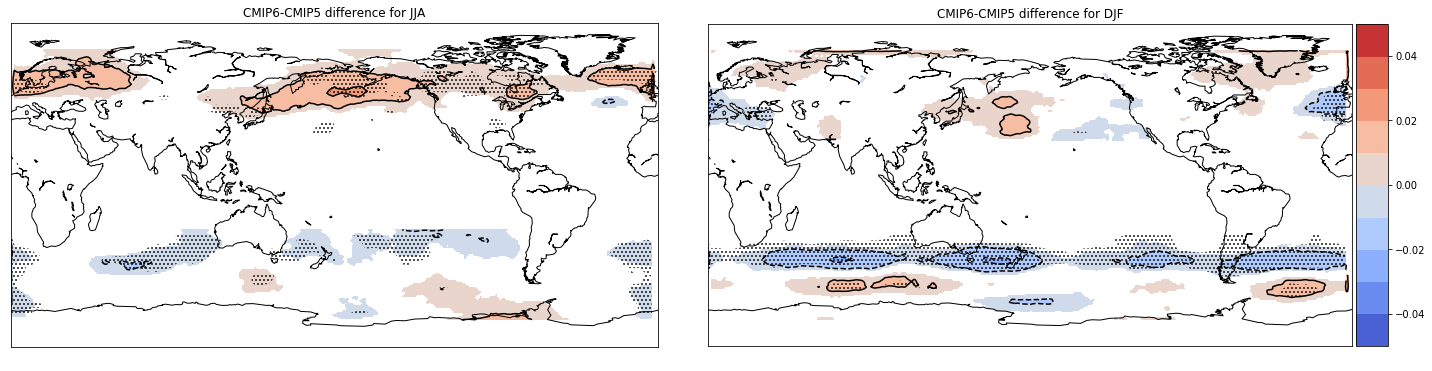

In [39]:
#What is the change from CMIP5 to CMIP6?

#cmip_diff_djf=cmip_djf['modelBlockMean']-avg_djf['modelBlockMean']
#cmip_diff_jja=cmip_jja['modelBlockMean']-avg_jja['modelBlockMean']

#csig_diff_djf=sigmat_calc(month_djf['modelSeasonMean'],cmonth_djf['modelSeasonMean'])
#csig_diff_jja=sigmat_calc(month_jja['modelSeasonMean'],cmonth_jja['modelSeasonMean'])

#djf_indices = np.absolute(cmip_diff_djf) < 0.005
#cmip_diff_djf.values[djf_indices] = np.nan
#jja_indices = np.absolute(cmip_diff_jja) < 0.005
#cmip_diff_jja.values[jja_indices] = np.nan

#sstr1='CMIP6-CMIP5 difference for JJA'
#sstr2='CMIP6-CMIP5 difference for DJF'

#plot_diffs_w_sig(cmip_diff_jja,sstr1,cmip_diff_djf,sstr2,diff_breaks,"coolwarm",csig_diff_jja,csig_diff_djf)

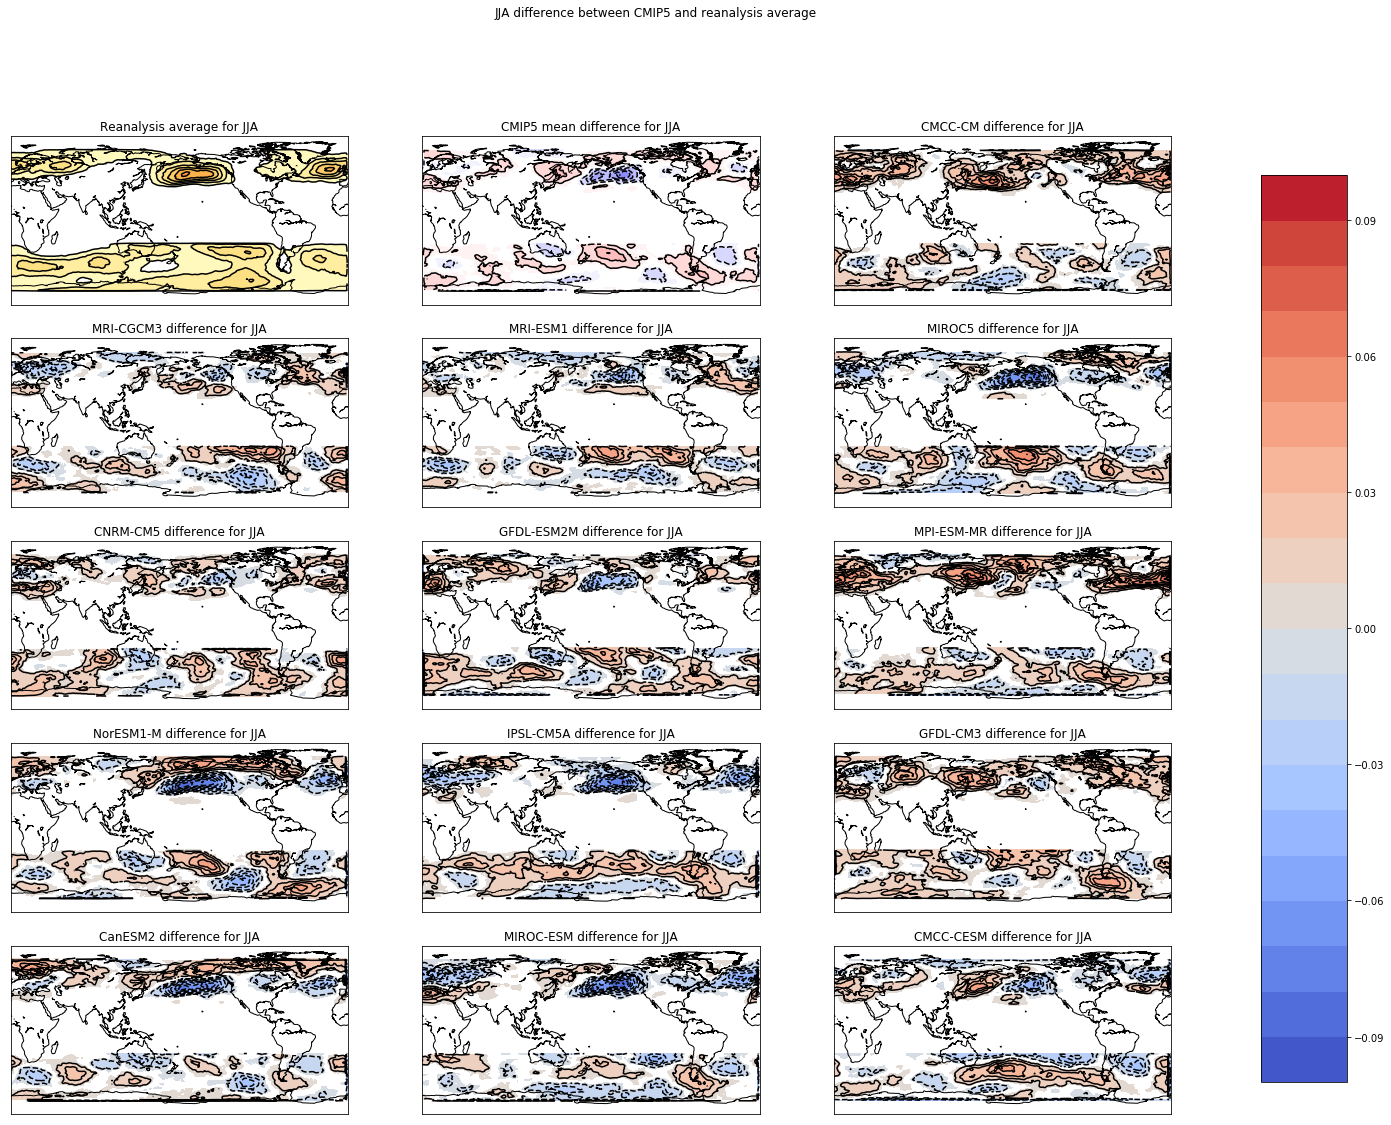

In [82]:
#Plot the differences between each model and the reanalysis mean
dc=0

#Plot the averages for Rean and Model, then individual models
fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(24,18))
fig.suptitle("JJA difference between CMIP5 and reanalysis average")
diff_breaks2=np.arange(-0.1,0.11,0.01)

v1=avg_jja['reanBlockMean']
v2=avg_jja['modelDiff']
plot_format(ax[0,0],v1,'Reanalysis average for JJA',b_breaks,'YlOrRd')
plot_format(ax[0,1],v2,'CMIP5 mean difference for JJA',diff_breaks2,'bwr')

mc=0
for i in range(5):
    for j in range(3):
        if (mc>1):
            mv=mc-2
            modname=dats_mod2[mv]
            v=avg_jja['{:}_diff'.format(modname)]
            #sig=sigmat_calc(month_jja['reanSeasonMean'],month_jja['{:}_SEASON_MEAN'.format(modname)])
            tstr='{:} difference for JJA'.format(modname)
            p=plot_format(ax[i,j],v,tstr,diff_breaks2,'coolwarm')
        mc+=1
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)
#plt.tight_layout()



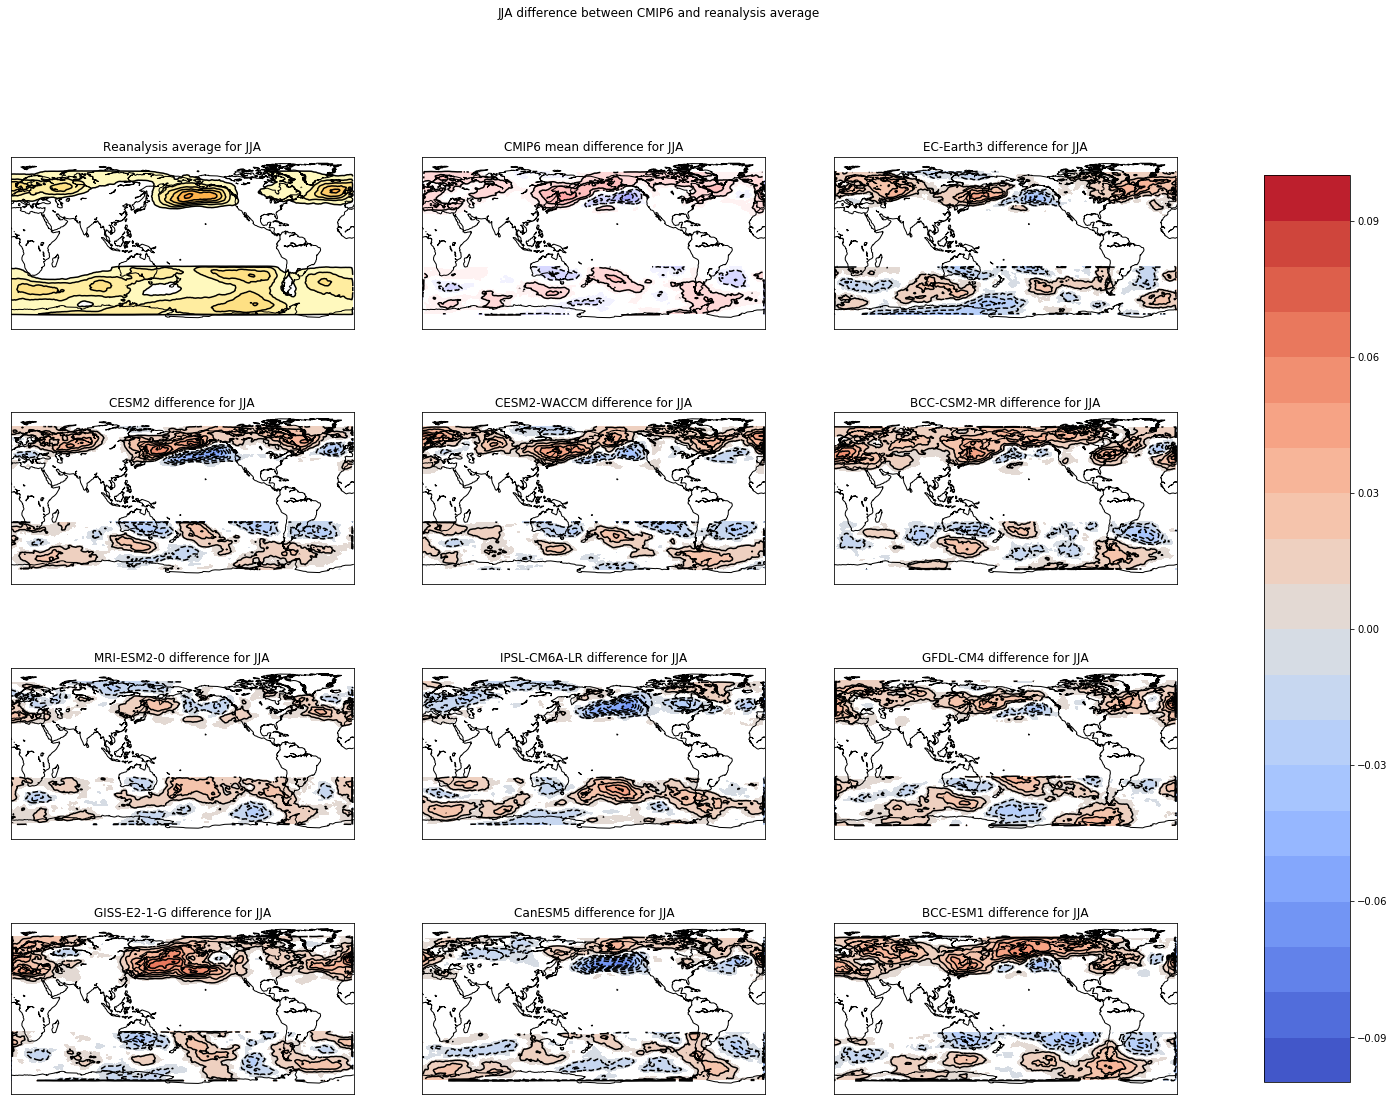

In [85]:
#Plot the averages for Rean and Model, then individual models
fig, ax = plt.subplots(4,3,sharex="col",sharey="row",figsize=(24,18))
fig.suptitle("JJA difference between CMIP6 and reanalysis average")
diff_breaks2=np.arange(-0.1,0.11,0.01)

v1=avg_jja['reanBlockMean']
v2=cmip_jja['modelDiff']
plot_format(ax[0,0],v1,'Reanalysis average for JJA',b_breaks,'YlOrRd')
plot_format(ax[0,1],v2,'CMIP6 mean difference for JJA',diff_breaks2,'bwr')

mc=0
for i in range(4):
    for j in range(3):
        if (mc>1):
            mv=mc-2
            modname=dats_cmip6[mv]
            v=cmip_jja['{:}_diff'.format(modname)]
            #sig=sigmat_calc(month_jja['reanSeasonMean'],month_jja['{:}_SEASON_MEAN'.format(modname)])
            tstr='{:} difference for JJA'.format(modname)
            p=plot_format(ax[i,j],v,tstr,diff_breaks2,'coolwarm')
        mc+=1
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)
#plt.tight_layout()

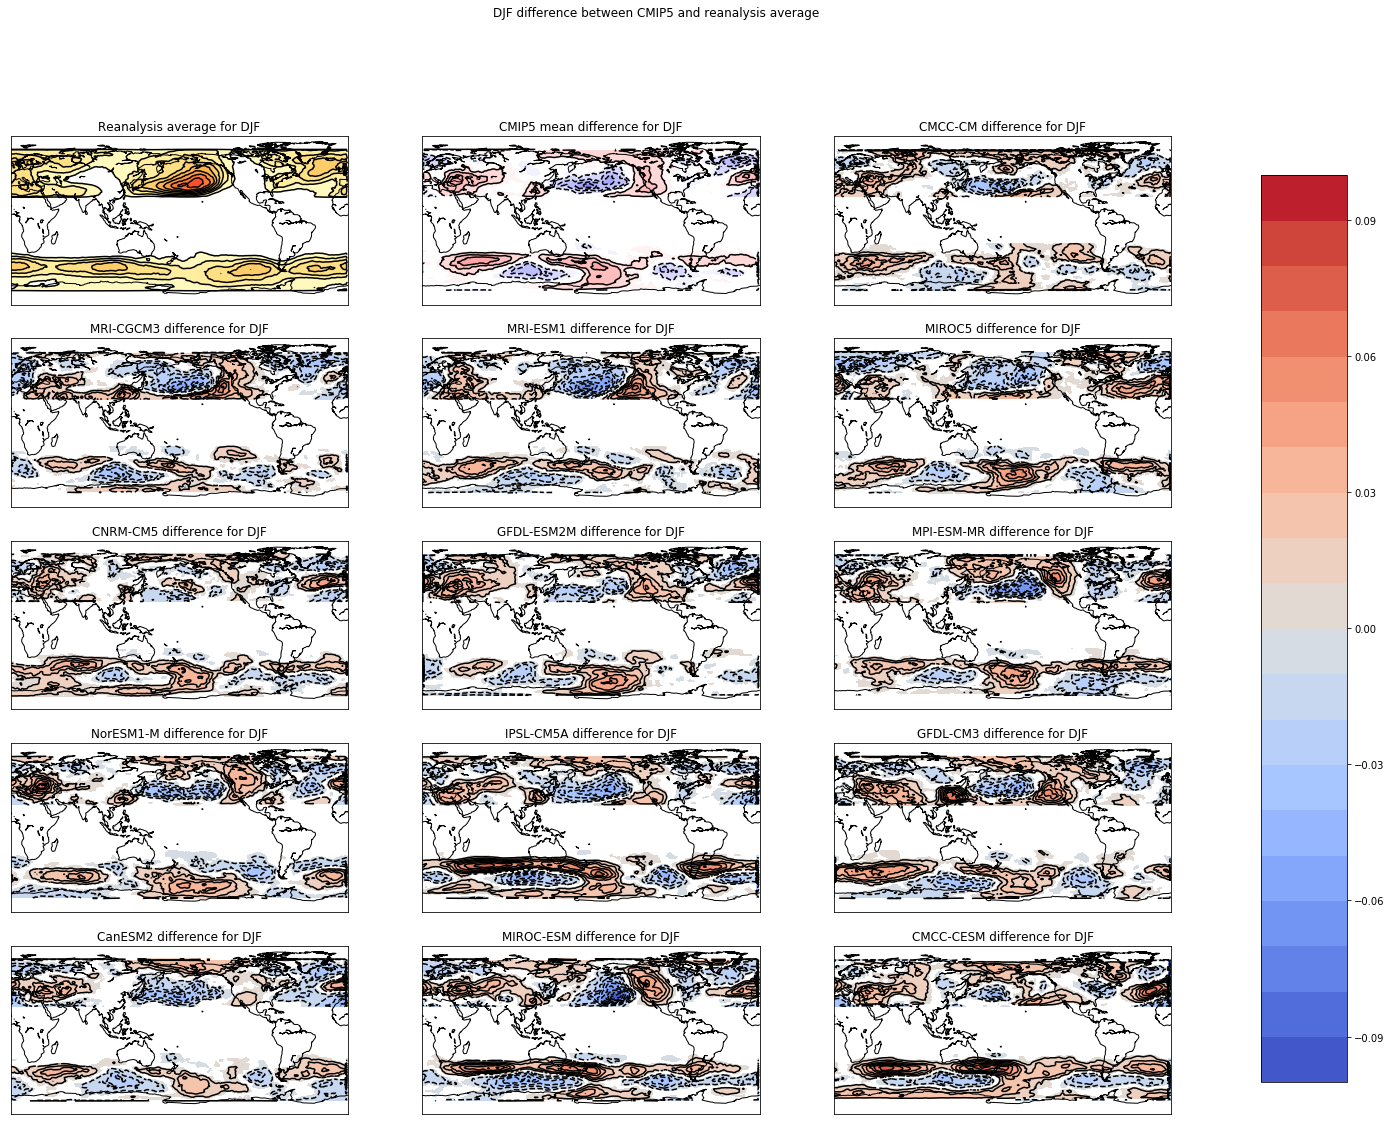

In [83]:
#Plot the averages for Rean and Model, then individual models
fig, ax = plt.subplots(5,3,sharex="col",sharey="row",figsize=(24,18))
fig.suptitle("DJF difference between CMIP5 and reanalysis average")
diff_breaks2=np.arange(-0.1,0.11,0.01)

v1=avg_djf['reanBlockMean']
v2=avg_djf['modelDiff']
plot_format(ax[0,0],v1,'Reanalysis average for DJF',b_breaks,'YlOrRd')
plot_format(ax[0,1],v2,'CMIP5 mean difference for DJF',diff_breaks2,'bwr')

mc=0
for i in range(5):
    for j in range(3):
        if (mc>1):
            mv=mc-2
            modname=dats_mod2[mv]
            v=avg_djf['{:}_diff'.format(modname)]
            #sig=sigmat_calc(month_jja['reanSeasonMean'],month_jja['{:}_SEASON_MEAN'.format(modname)])
            tstr='{:} difference for DJF'.format(modname)
            p=plot_format(ax[i,j],v,tstr,diff_breaks2,'coolwarm')
        mc+=1
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)

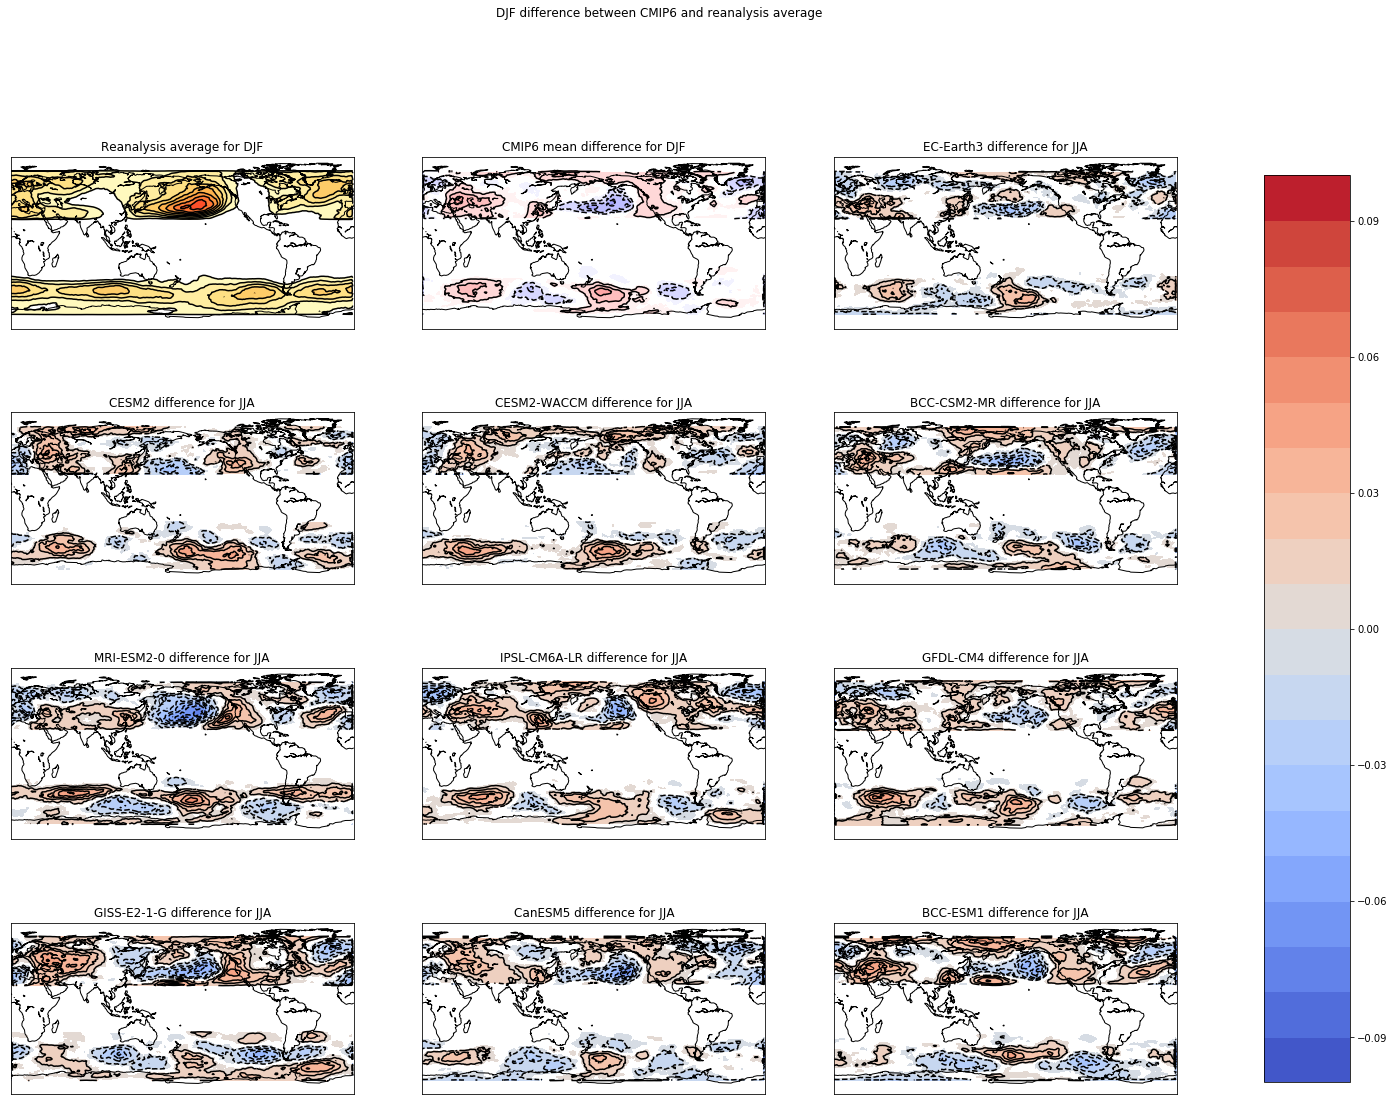

In [86]:
#Plot the averages for Rean and Model, then individual models
fig, ax = plt.subplots(4,3,sharex="col",sharey="row",figsize=(24,18))
fig.suptitle("DJF difference between CMIP6 and reanalysis average")
diff_breaks2=np.arange(-0.1,0.11,0.01)

v1=avg_djf['reanBlockMean']
v2=cmip_djf['modelDiff']
plot_format(ax[0,0],v1,'Reanalysis average for DJF',b_breaks,'YlOrRd')
plot_format(ax[0,1],v2,'CMIP6 mean difference for DJF',diff_breaks2,'bwr')

mc=0
for i in range(4):
    for j in range(3):
        if (mc>1):
            mv=mc-2
            modname=dats_cmip6[mv]
            v=cmip_djf['{:}_diff'.format(modname)]
            #sig=sigmat_calc(month_jja['reanSeasonMean'],month_jja['{:}_SEASON_MEAN'.format(modname)])
            tstr='{:} difference for JJA'.format(modname)
            p=plot_format(ax[i,j],v,tstr,diff_breaks2,'coolwarm')
        mc+=1
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)

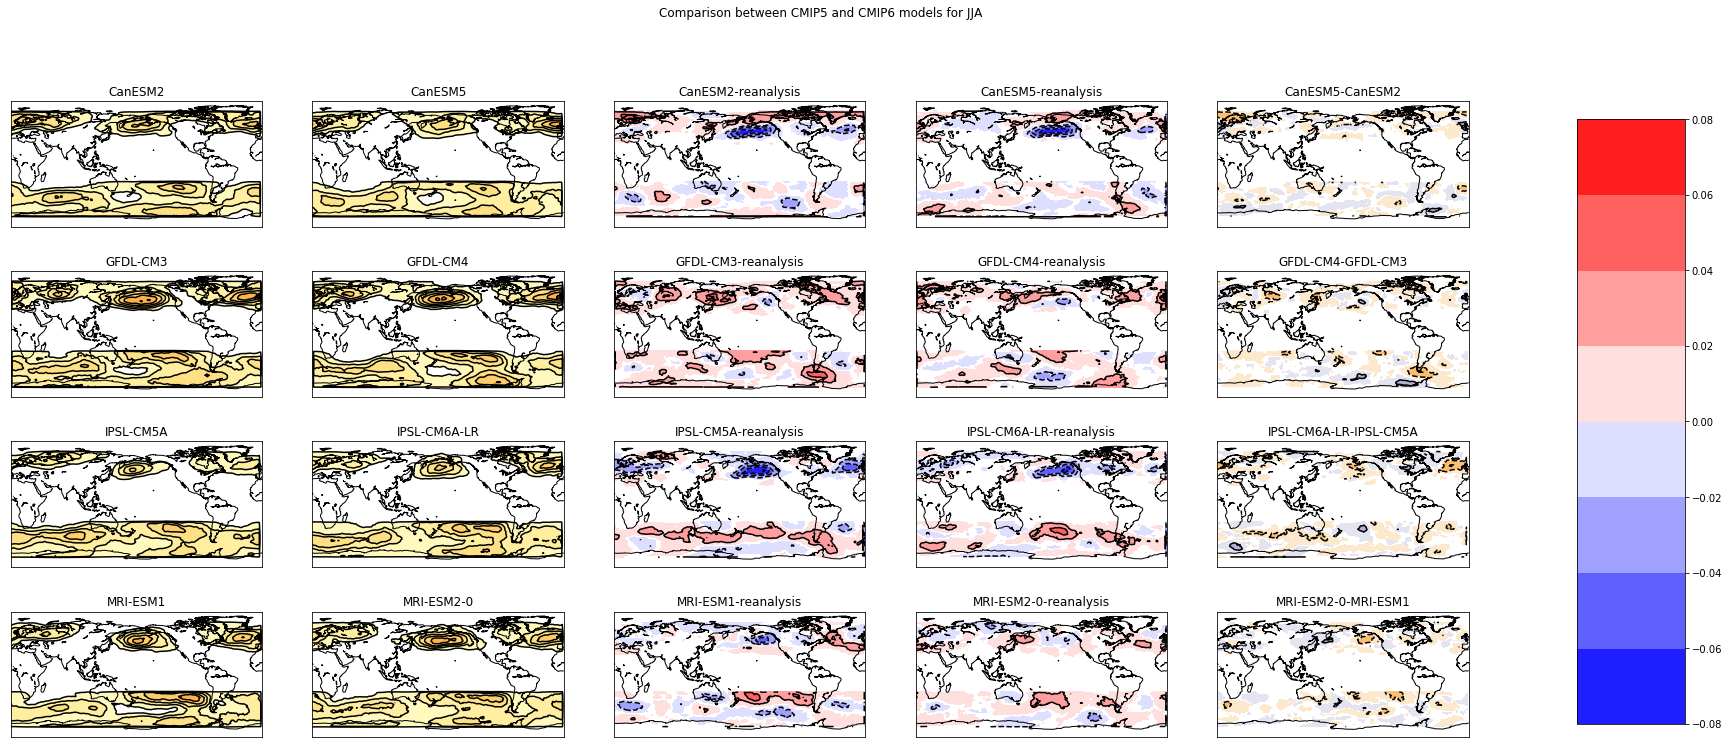

In [107]:
#Models that are similar between the two CMIP runs
m1=['CanESM2','GFDL-CM3','IPSL-CM5A','MRI-ESM1']
m2=['CanESM5','GFDL-CM4','IPSL-CM6A-LR','MRI-ESM2-0']
diff_breaks2=np.arange(-0.08,0.09,0.02)
fig,ax = plt.subplots(4,5,sharex='col',sharey='row',figsize=(30,12))
fig.suptitle('Comparison between CMIP5 and CMIP6 models for JJA')
rean=avg_jja['reanBlockMean']
for i in range(4):
    mod1=m1[i]
    mod2=m2[i]
    v1=avg_jja[mod1]
    v2=cmip_jja[mod2]
    #vdiff=v2-v1
    
    diff1=v1-rean
    diff2=v2-rean
    
    #Change in the error-- distance from reanalysis
    d1abs=np.absolute(diff1)
    d2abs=np.absolute(diff2)
    vdiff=d2abs-d1abs
    
    l0=np.absolute(diff1)<0.005
    diff1.values[l0]=np.nan
    
    l0=np.absolute(diff2)<0.005
    diff2.values[l0]=np.nan
    
        
    l0=np.absolute(vdiff) < 0.005
    vdiff.values[l0]=np.nan
    
    plot_format(ax[i,0],v1,mod1,b_breaks,'YlOrRd')
    plot_format(ax[i,1],v2,mod2,b_breaks,'YlOrRd')
    p=plot_format(ax[i,2],diff1,'{:}-reanalysis'.format(mod1),diff_breaks2,'bwr')
    p=plot_format(ax[i,3],diff2,'{:}-reanalysis'.format(mod2),diff_breaks2,'bwr')
    plot_format(ax[i,4],vdiff,'{:}-{:}'.format(mod2,mod1),diff_breaks2,'PuOr')
    
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)

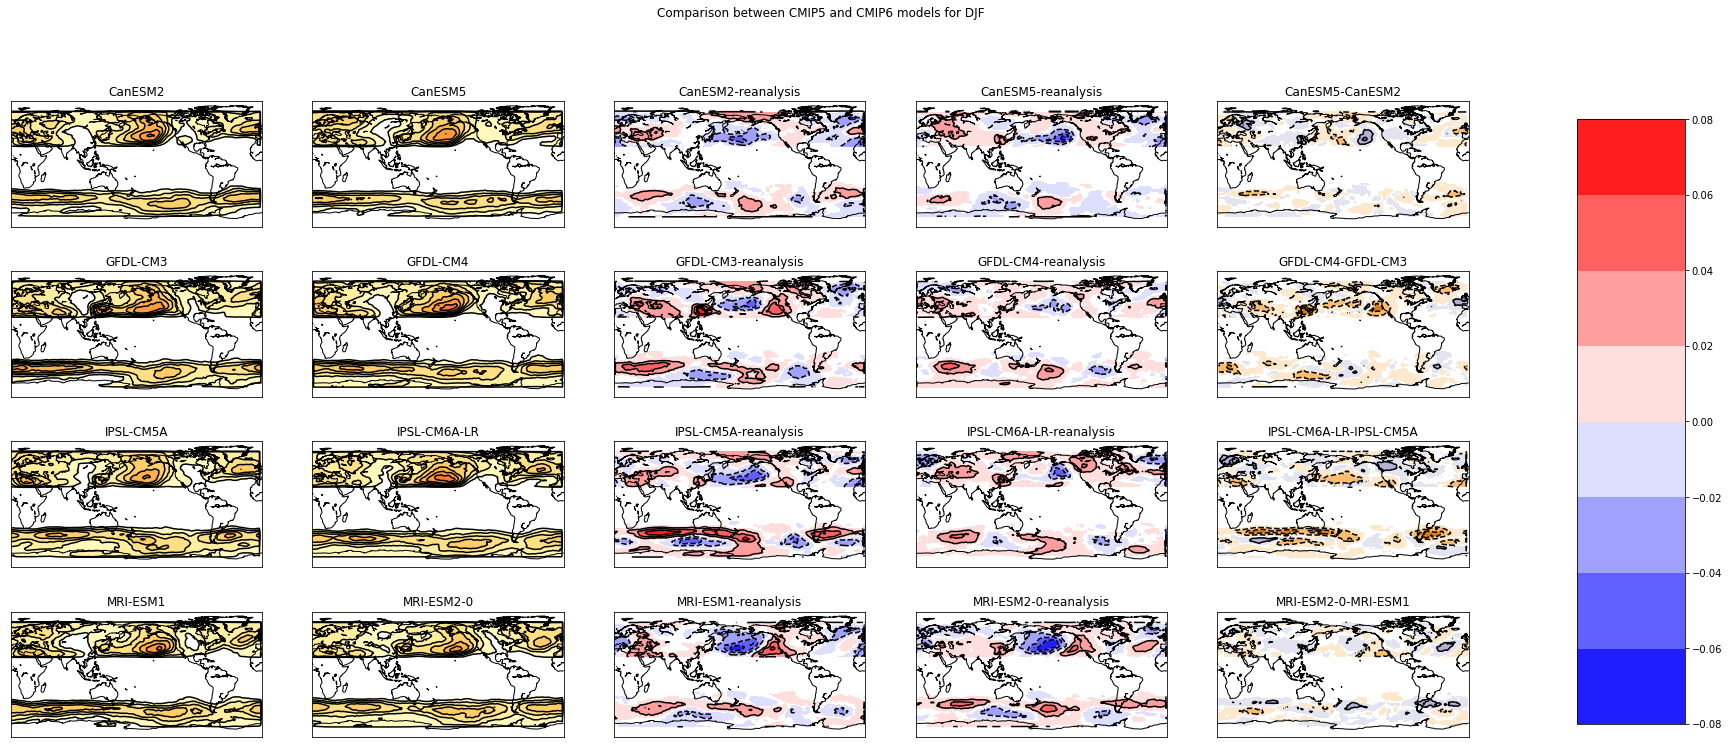

In [105]:
#Models that are similar between the two CMIP runs
m1=['CanESM2','GFDL-CM3','IPSL-CM5A','MRI-ESM1']
m2=['CanESM5','GFDL-CM4','IPSL-CM6A-LR','MRI-ESM2-0']
diff_breaks2=np.arange(-0.08,0.09,0.02)
fig,ax = plt.subplots(4,5,sharex='col',sharey='row',figsize=(30,12))
fig.suptitle('Comparison between CMIP5 and CMIP6 models for DJF')
rean=avg_djf['reanBlockMean']
for i in range(4):
    mod1=m1[i]
    mod2=m2[i]
    v1=avg_djf[mod1]
    v2=cmip_djf[mod2] 
    #vdiff=v2-v1
    
    diff1=v1-rean
    diff2=v2-rean
    
    #Change in the error-- distance from reanalysis
    d1abs=np.absolute(diff1)
    d2abs=np.absolute(diff2)
    vdiff=d2abs-d1abs
    
    l0=np.absolute(diff1)<0.005
    diff1.values[l0]=np.nan
    
    l0=np.absolute(diff2)<0.005
    diff2.values[l0]=np.nan
    
        
    l0=np.absolute(vdiff) < 0.005
    vdiff.values[l0]=np.nan
    
    plot_format(ax[i,0],v1,mod1,b_breaks,'YlOrRd')
    plot_format(ax[i,1],v2,mod2,b_breaks,'YlOrRd')
    p=plot_format(ax[i,2],diff1,'{:}-reanalysis'.format(mod1),diff_breaks2,'bwr')
    p=plot_format(ax[i,3],diff2,'{:}-reanalysis'.format(mod2),diff_breaks2,'bwr')
    plot_format(ax[i,4],vdiff,'{:}-{:}'.format(mod2,mod1),diff_breaks2,'PuOr')
    
cbar_ax=fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(p,cax=cbar_ax)
    

In [21]:
#Function to find the mean/sd of each variable in the specified list and normalize the variables
def find_mean_sd(vlist,allframe,reg_str,sstr):
    dict_stats={'region':reg_str,'season':sstr}
    for v in vlist:
        dict_temp={}
        dict_temp['mean'] = allframe[v].mean()
        dict_temp['sd'] = allframe[v].std()
        dict_stats[v] = dict_temp
    return(dict_stats)

#Now a function for reading in the stats
def read_summ_stats(reg_str,sstr,dataset,vlist,modtype):
    basedir="/global/cscratch1/sd/marielp"
    summ_frame=pd.DataFrame()
    all_frame=pd.DataFrame()
    for d in dataset:
        fname_summ="{:}/{:}/STATS_SUMM/{:}_{:}_{:}_summtable.csv".format(basedir,d,d,sstr,reg_str)
        fname_tot="{:}/{:}/STATS_SUMM/{:}_{:}_{:}_indicestable.csv".format(basedir,d,d,sstr,reg_str)

        dcurr=sorted(glob.glob("{:}/{:}/BLOBS_NOREGIONAL/*DJF_blobs_noregional.nc".format(base_dir,d)))[0]
        d_mf = xa.open_dataset(dcurr)
        
        summ_sub=pd.read_csv(fname_summ)
        summ_sub['region']=reg_str
        summ_sub['season']=sstr
        summ_sub['mean_area']=summ_sub['mean_area_km']/(10**6)
        summ_sub['abs_centlat']=abs(summ_sub['mean_centlat'])
        tot_sub=pd.read_csv(fname_tot)
        
        all_frame = all_frame.append(summ_sub)
        
        d_dict={}
        d_dict['var']=d
        d_dict['region']=reg_str
        d_dict['season']=sstr
        d_dict['latres']=d_mf['lat'].values[1]-d_mf['lat'].values[0]
        d_dict['lonres']=d_mf['lon'].values[1]-d_mf['lon'].values[0]
        d_dict['# Features']=len(summ_sub)
        d_dict['Merged']=len(summ_sub[summ_sub['merged']=='YES'])
        d_dict['Duration']=summ_sub['duration_days'].mean()
        d_dict['Days/season']=len(list(set(tot_sub['time'])))/len(list(set(tot_sub['year'])))
        d_dict['Lat']=summ_sub['mean_centlat'].mean()
        d_dict['Size']=tot_sub['area_km'].mean()/(10**6)
        d_dict['Speed']=summ_sub['zonal_speed_km'].mean()
        d_dict['AI']=summ_sub['mean_AI'].mean()
        d_dict['BI']=summ_sub['mean_BI'].mean()
        summ_frame=summ_frame.append(d_dict,ignore_index=True)
        
    colnames_tab=d_dict.keys()
    keys_list =list(colnames_tab)[3:]
    summ_frame=summ_frame[colnames_tab]
    mean_dict={}
    mean_dict['var'] = 'Mean'
    mean_dict['region'] = reg_str
    mean_dict['season'] = sstr
    for k in keys_list:
        mean_dict[k]=summ_frame[k].mean()

    summ_frame_sort=summ_frame.sort_values(by=['latres','lonres'])
    summ_frame_sort = summ_frame_sort.append(mean_dict,ignore_index=True)
    norms_dict = find_mean_sd(vlist,all_frame,reg_str,sstr)
    summ_frame['model'] = modtype
    all_frame['model'] = modtype
    summ_frame_sort['model'] = modtype
    
    return({'SUMM':summ_frame, 'ALL':all_frame, 'SORT':summ_frame_sort,'MEAN_SD':norms_dict,'MODTYPE':modtype})

In [22]:
summ_all = pd.DataFrame()
all_all = pd.DataFrame()
sort_all = pd.DataFrame()
norm_vals = {}
norm_mod_vals={}
norm_all = pd.DataFrame()
var_str=['duration_days',
 'abs_centlat',
 'mean_area',
 'zonal_speed_km',
 'mean_AI',
 'mean_BI']

for r in ["NH","SH"]:
    for s in ["JJA","DJF"]:
        #Read in the reanalysis data and model data
        rean_temp = read_summ_stats(r,s,dats_mod,var_str,'rean')
        model_temp = read_summ_stats(r,s,dats_mod2,var_str,'model')
        summ_all = summ_all.append(rean_temp['SUMM'])
        summ_all = summ_all.append(model_temp['SUMM'])
        all_all = all_all.append(rean_temp['ALL'])
        all_all = all_all.append(model_temp['ALL'])
        sort_all = sort_all.append(rean_temp['SORT'])
        sort_all = sort_all.append(model_temp['SORT'])
        norm_vals['rean_{:}_{:}'.format(r,s)]=rean_temp['MEAN_SD']
        norm_mod_vals['model_{:}_{:}'.format(r,s)]=model_temp['MEAN_SD']
        #Normalize the data
        norm_frame = pd.DataFrame()
        norm_mframe = pd.DataFrame()
        norm_frame['var'] = rean_temp['ALL']['var']
        norm_mframe['var'] = model_temp['ALL']['var']
        for v in var_str:
            meanval = rean_temp['MEAN_SD'][v]['mean']
            sdval = rean_temp['MEAN_SD'][v]['sd']
            norm_frame[v] = (rean_temp['ALL'][v]-meanval)/sdval
            norm_mframe[v] = (model_temp['ALL'][v]-meanval)/sdval
        norm_frame['model'] = rean_temp['MODTYPE']
        norm_frame['region'] = r
        norm_frame['season'] = s
        norm_mframe['model'] = model_temp['MODTYPE']
        norm_mframe['region'] = r
        norm_mframe['season'] = s
        norm_all = norm_all.append(norm_frame)
        norm_all = norm_all.append(norm_mframe)
    


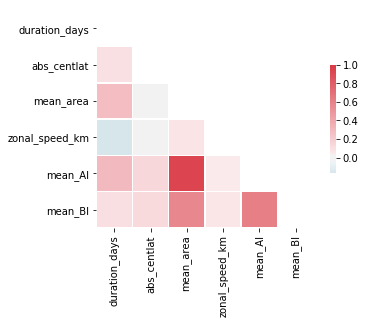

In [31]:
cn=norm_all.corr()
mask = np.zeros_like(cn, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cn, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
#Do the pearson correlation and RMSE for both the model average and the individual models vs the reanalysis average
#Store the values in a table

#Select the NH and SH areas
def corr_calc(bot_coord,top_coord,model_avg,a_name,r_name):
    a_slice=model_avg[a_name].sel(lat=slice(bot_coord,top_coord))
    r_slice=model_avg[r_name].sel(lat=slice(bot_coord,top_coord))
    a_flat=np.ndarray.flatten(a_slice.values)
    r_flat=np.ndarray.flatten(r_slice.values)
    return(pearsonr(a_flat,r_flat))

#Adding on the RMSE calculation for each region
def rmse_region(rean,mod,bot_coord,top_coord):
    r_slice=rean.sel(lat=slice(bot_coord,top_coord))
    m_slice=mod.sel(lat=slice(bot_coord,top_coord))
    diff_slice=m_slice-r_slice
    maxmin=r_slice.values.max()-r_slice.values.min()
    iqr=np.quantile(r_slice.values,0.75)-np.quantile(r_slice.values,0.25)
    #print(maxmin)
    #print(iqr)
    rmse = np.sqrt((diff_slice.values**2).mean())
    #print(rmse)
    nrmse=rmse/maxmin
    return(nrmse)

compare_table = pd.DataFrame()
cols=['region','season','var','corr','nrmse','corr_dist']
rean_v="reanBlockMean_WGT"
mm_v='modelBlockMean_WGT'

for r in ['NH','SH']:
    if r=='NH':
        tb=75
        bb=25
    else: 
        tb=-25
        bb=-75
    for s in ['JJA','DJF']:
        if s=='JJA':
            dat=avg_jja
        else:
            dat=avg_djf
        store_dict={}
        store_dict['region']=r
        store_dict['season']=s
        store_dict['var']='mean'
        store_dict['corr']=corr_calc(bb,tb,dat,rean_v,mm_v)[0]
        store_dict['corr_dist']=1-abs(store_dict['corr'])
        store_dict['nrmse']=rmse_region(dat[rean_v],dat[mm_v],bb,tb)
        compare_table = compare_table.append(store_dict,ignore_index=True)
        for d in dats_mod2:
            store_dict['var']=d
            mm_d = '{:}_WGT'.format(d)
            store_dict['corr']=corr_calc(bb,tb,dat,rean_v,mm_d)[0]
            store_dict['corr_dist']=1-abs(store_dict['corr'])
            store_dict['nrmse']=rmse_region(dat[rean_v],dat[mm_d],bb,tb)
            compare_table=compare_table.append(store_dict,ignore_index=True)
compare_table=compare_table[cols]


{'region': 'NH',
 'season': 'JJA',
 'duration_days': {'mean': 7.960539460539461, 'sd': 3.6427995850826735},
 'mean_centlat': {'mean': 53.18576713312304, 'sd': 8.779358916577161},
 'mean_area_km': {'mean': 3008723.005685013, 'sd': 1089447.9091626224},
 'zonal_speed_km': {'mean': 7.593780882623298, 'sd': 5.118997934901604},
 'mean_AI': {'mean': 3.8745476047943668, 'sd': 1.8153162116483839},
 'mean_BI': {'mean': 1.1847569536335611, 'sd': 0.3930904070047078}}

In [25]:
#So we have the means/sd for both reanalysis and models for each of the distributions
#We also have all of the z-scores (with respect to the reanalysis mean)
#What would we output for the stoplight diagram?
#For now we'll do means for the MMM as well as each model

def output_mean_z_scores(input_data,mean_sd,rean_list,mod_list,vlist,vfmt,r,s,outname):
    store_frame=pd.DataFrame()

    #multi model mean
    store_dict={}
    knum=len(vlist)+1
    klist=[None]*knum
    klist[0]='model'
    colnames=[None]*knum
    colnames[0]='model'

    #Get the dictionary with the proper region values
    mean_dict=mean_sd['rean_{:}_{:}'.format(r,s)]
    
    #Multi-reananalysis mean
    store_dict['model']='Multi-rean mean'
    rean_data=input_data[input_data['model'].str.match('rean')&input_data['region'].str.match(r)&input_data['season'].str.match(s)]
    
    j=1
    for v in vlist:
        klist[j]=v
        vname=vfmt[j-1]
        mval=mean_dict[v]['mean']
        colnames[j]='{:}={:.2f}'.format(vname,mval)
        x=rean_data[v].mean()
        store_dict[v]=x
        j+=1   
    store_frame=store_frame.append(store_dict,ignore_index=True)

    #Now repeat for each of the models
    for d in rean_list:
        store_dict={}
        store_dict['model']=d
        model_data=input_data[input_data['var'].str.match(d)&input_data['region'].str.match(r)&input_data['season'].str.match(s)]

        for v in vlist:
            vname=v
            x=model_data[v].mean()
            store_dict[vname]=x
        store_frame=store_frame.append(store_dict,ignore_index=True)

    
    #Multi-model mean
    store_dict={}
    store_dict['model']='Multi-model mean'
    model_data=input_data[input_data['model'].str.match('model')&input_data['region'].str.match(r)&input_data['season'].str.match(s)]

    for v in vlist:
        x=model_data[v].mean()
        store_dict[v]=x
    store_frame = store_frame.append(store_dict,ignore_index=True)

    #Now repeat for each of the models
    for d in mod_list:
        store_dict={}
        store_dict['model']=d

        model_data=input_data[input_data['var'].str.match(d)&input_data['region'].str.match(r)&input_data['season'].str.match(s)]

        for v in vlist:
            vname=v
            x=model_data[v].mean()
            store_dict[vname]=x
        store_frame=store_frame.append(store_dict,ignore_index=True)
    store_frame=store_frame[klist]
    store_frame.columns=colnames
    store_frame.to_csv(outname,index=False)



In [26]:
var_str=['duration_days',
 'abs_centlat',
 'mean_area',
 'zonal_speed_km',
 'mean_AI',
 'mean_BI']
var_fmt=['BD','CL','BA','BS','AI','BI']

for r in ['NH','SH']:
    for s in ['DJF','JJA']:
        sname='~/model_mean_diff_{:}_{:}.csv'.format(r,s)
        output_mean_z_scores(norm_all,norm_vals,dats_mod,dats_mod2,var_str,var_fmt,r,s,sname)



In [ ]:
#Stats for reanalysis data
norm_rean = norm_all[norm_all['model'].str.match('rean')]
summ_rean = all_all[all_all['model'].str.match('rean')]
#for r in ['NH','SH']:
#    for s in ['JJA','DJF']:
#       for v in var_str:
#            var_sel = norm_rean[norm_rean['region'].str.match(r) & norm_rean['season'].str.match(s)][['var',v]]
#            x=[var_sel[var_sel["var"]==d][v] for d in dats_mod]
 #           print("results for {:} {:}, {:}".format(r,s,v))
 #           print(kruskal(*x))

for r in ['NH','SH']:
    for s in ['JJA','DJF']:
        for v in var_str:
            var_sel = summ_rean[summ_rean['region'].str.match(r) & summ_rean['season'].str.match(s)][['var',v]]
            x=[var_sel[var_sel['var']==d][v] for d in dats_mod]
            k=kruskal(*x)
            if k.pvalue<0.8:
                print("result for {:} ({:} {:}) is {:}".format(v,r,s,k))


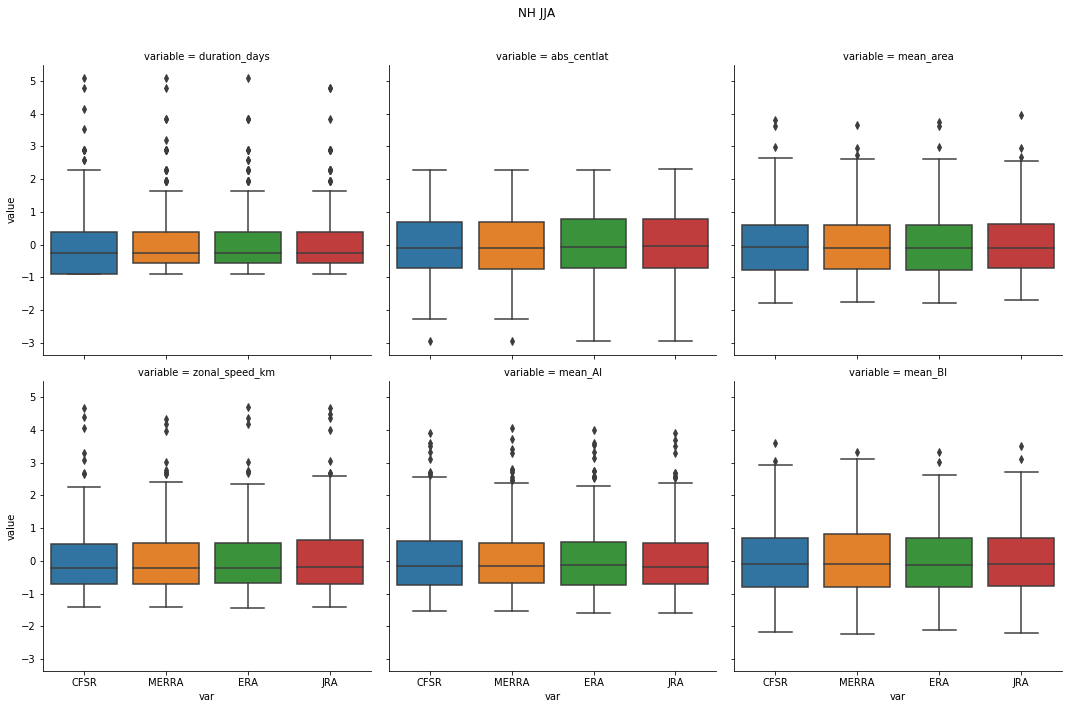

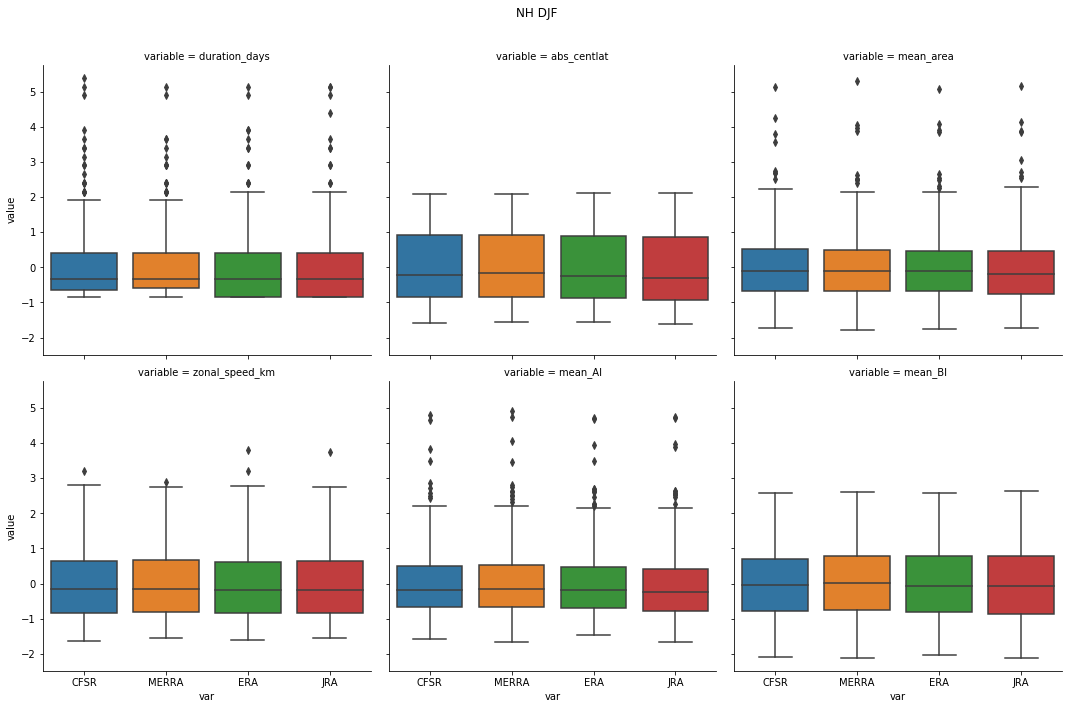

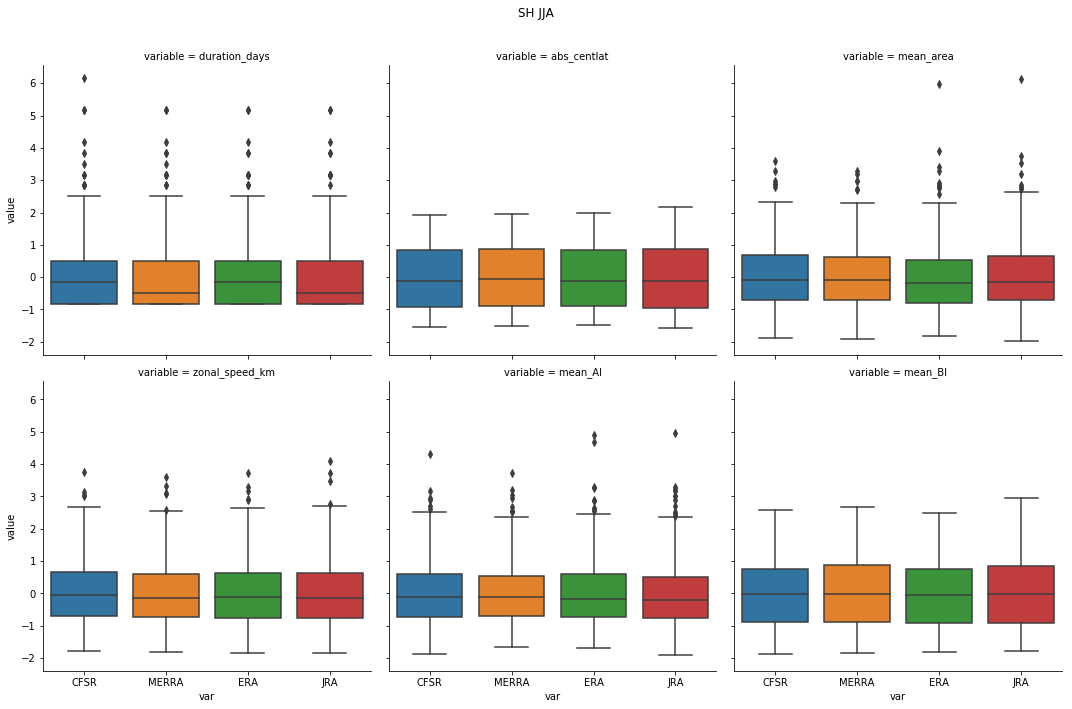

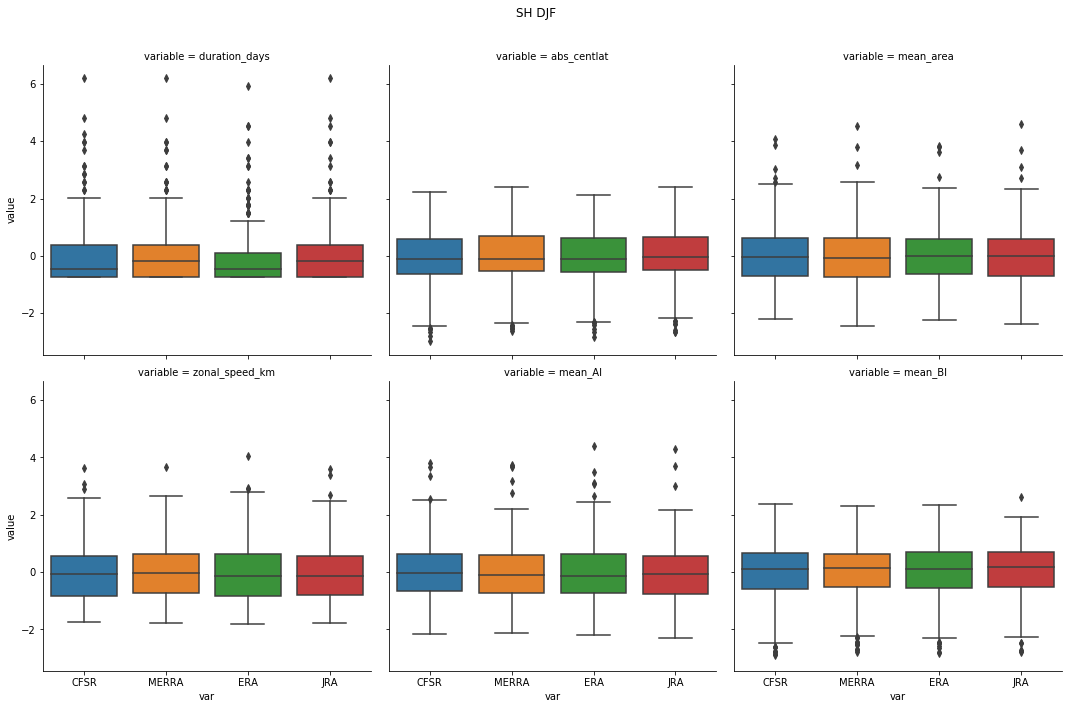

In [27]:
norm_melt = norm_all.melt(id_vars=['var','region','season','model'])
norm_rean = norm_melt[norm_melt['model'].str.match('rean')]
norm_mod = norm_melt[norm_melt['model'].str.match('model')]


#Make a facet plot of the reanalysis values
for r in ['NH','SH']:
    for s in ['JJA','DJF']:
        norm_sub=norm_rean[norm_rean['region'].str.match(r) & norm_rean['season'].str.match(s)]
        g=sns.catplot(data=norm_sub,col='variable',x='var',y='value',kind='box',col_wrap=3)
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle("{:} {:}".format(r,s))

In [ ]:
# #Mean/sd of each?
# norm_vals[['region','season','duration_days']]
# norm_copy = norm_vals
# for v in var_str:
#     norm_copy=pd.concat([norm_copy.drop([v],axis=1),norm_copy[v].apply(pd.Series)],axis=1)
# cols_old = norm_copy.columns
# print(cols_old)


In [ ]:
# for r in ['NH','SH']:
#     for s in ['JJA','DJF']:
#         norm_sub = norm_melt[norm_melt['region'].str.match(r) & norm_melt['season'].str.match(s)]
#         sns.catplot(data=norm_sub,col='variable',x='var',y='value',kind='box',hue='model')
# #sns.catplot(data=norm_melt,col='season',row='region',kind='box',x='variable',y='value',hue='model')
# #plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)

In [ ]:
# #Let's try some PCA shit
# pca = PCA(n_components=2)
# #Try training on reanalysis data
# data_train = norm_all[norm_all['model'].str.match('rean')][var_str]
# pca.fit(data_train)
# data_transform = pca.transform(data_train)
# data_test = norm_all[norm_all['model'].str.match('model')][var_str]
# data_transform_test = pca.transform(data_test)


In [ ]:
# print(pca.explained_variance_ratio_)
# print(pd.DataFrame(pca.components_,columns=var_str))